# Sandwich versus Bootstrap Standard Errors

In [50]:
import abc
import collections
import multiprocessing
import sys
from typing import Any, Callable, NamedTuple, Sequence, Tuple

from absl import app
from absl import flags
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import tensorflow as tf
from tensorflow.python.ops import gen_array_ops
from tensorflow.python.ops import gen_linalg_ops
from tensorflow.python.ops import parallel_for
pfor = sys.modules['tensorflow.python.ops.parallel_for.pfor']

tf.enable_v2_behavior()
np.set_printoptions(suppress=True)

In [2]:
@pfor.RegisterPForWithArgs('MatrixBandPart', gen_array_ops.matrix_band_part)
@pfor.RegisterPForWithArgs('MatrixDiag', gen_array_ops.matrix_diag)
def _convert_matrix_diag(pfor_input, op_type, op_func):
    del op_type
    return pfor.wrap(op_func(*[x.t for x in pfor_input.inputs]), True)

@pfor.RegisterPForWithArgs('MatrixSetDiag', gen_array_ops.matrix_set_diag)
@pfor.RegisterPForWithArgs('MatrixTriangularSolve', gen_linalg_ops.matrix_triangular_solve)
def _convert_matrix_solve(pfor_input, op_type, op_func):
    del op_type
    pfor_input.stack_inputs()
    return pfor.wrap(op_func(*[x.t for x in pfor_input.inputs]), True)

## Data

In [3]:
orthodont_data = pd.read_csv('../hw4/orthodont.csv')
orthodont_data = orthodont_data.set_index('Subject')
orthodont_data.head(8)

,distance,age,Sex
Subject,,,
M01,26.0,8,Male
M01,25.0,10,Male
M01,29.0,12,Male
M01,31.0,14,Male
M02,21.5,8,Male
M02,22.5,10,Male
M02,23.0,12,Male
M02,26.5,14,Male


In [4]:
def make_covariates(data_frame):    
    age = (data_frame['age'] - 8).values
    is_female = (data_frame['Sex'] == 'Female').values.astype(np.float64)
    return np.column_stack((
        np.ones(len(data_frame)),
        age,
        is_female,
        age*is_female,        
    ))

def make_response(data_frame):
    return data_frame['distance'].values

X = tf.convert_to_tensor(
    [make_covariates(orthodont_data.loc[i]) for i in np.unique(orthodont_data.index)],
    tf.float32)
y = tf.expand_dims(tf.convert_to_tensor(
    [make_response(orthodont_data.loc[i]) for i in np.unique(orthodont_data.index)],
    tf.float32), -1)

## Cluster Correlation Structure

In [5]:
def make_covariance_homoscedastic(log_variance):
    """Makes diagonal homoscedastic covariance structure."""
    return tf.exp(log_variance)*tf.eye(4)

In [6]:
def make_covariance_exchangeable(log_covariance_params):
    """Makes heteroscedastic, exchangeble covariance structure."""
    standard_errors = tf.exp(log_covariance_params[:-1])  # First entries are standard errors.
    rho = tf.exp(log_covariance_params[-1])  # Last entry is correlation.
    correlation = tf.ones((4, 4), dtype=tf.float32)*rho + tf.eye(4)*(1. - rho)
    return correlation*standard_errors*tf.expand_dims(standard_errors, -1)

## REML Loss

In [7]:
def solve_beta(X, y, weights):
    projected_X = tf.reduce_sum(tf.matmul(tf.tensordot(tf.transpose(X, [0, 2, 1]), weights, 1), X), 0)
    projected_y = tf.reduce_sum(tf.matmul(tf.tensordot(tf.transpose(X, [0, 2, 1]), weights, 1), y), 0)
    return tf.linalg.cholesky_solve(tf.linalg.cholesky(projected_X), projected_y)

def loss_fn(X, y, covariance):
    weights = tf.linalg.cholesky_solve(tf.linalg.cholesky(covariance), tf.eye(4))        
    beta = solve_beta(X, y, weights)     
    residuals = y - tf.tensordot(X, beta, 1)
    weighted_squared_error = tf.matmul(
        tf.tensordot(tf.transpose(residuals, [0, 2, 1]), weights, 1), residuals)
    loss = tf.reduce_mean(weighted_squared_error) + tf.linalg.logdet(covariance)    
    reml_loss = tf.reduce_sum(tf.matmul(tf.tensordot(tf.transpose(X, [0, 2, 1]), weights, 1), X), 0)
    return loss + tf.linalg.logdet(reml_loss) / tf.cast(tf.shape(y)[0], tf.float32)

## Optimization

Minimizes REML loss with Newton-Raphson algorithm

In [8]:
class CovarianceSpec(NamedTuple('CovarianceSpec', [
    ('initial_params', np.array),
    ('make_covariance', Callable[[tf.Tensor], tf.Tensor]),
])):
    """Encapsulates covariance parameters."""

def fit(X, y, covariance_spec):
    covariance_params = tf.Variable(covariance_spec.initial_params)
    for i in range(16):
        with tf.GradientTape(persistent=True) as outer_tape:
            with tf.GradientTape() as inner_tape:
                loss = loss_fn(X, y, covariance_spec.make_covariance(covariance_params))
            gradients = inner_tape.gradient(loss, covariance_params)
        hessian = outer_tape.jacobian(gradients, covariance_params,
                                      parallel_iterations=4, experimental_use_pfor=False)            
        covariance_params.assign_add(tf.reshape(
            tf.linalg.cholesky_solve(tf.linalg.cholesky(hessian), -tf.expand_dims(gradients, -1)),
            covariance_params.shape))
    return covariance_params

In [9]:
log_variance = fit(
    X, y,
    CovarianceSpec(initial_params=[0.], make_covariance=make_covariance_homoscedastic))
tf.sqrt(tf.exp(log_variance)).numpy()

W0221 06:53:33.943777 140482936473344 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:80: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
W0221 06:53:33.964406 140482936473344 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


array([2.256949], dtype=float32)

## Standard Error Estimates

The ML covariance estimate assumes that the covariance model is correct.

In [18]:
def ml_covariance(X, weights):
    covariance = tf.reduce_sum(tf.matmul(tf.tensordot(tf.transpose(X, [0, 2, 1]), weights, 1), X), 0)
    return tf.linalg.cholesky_solve(tf.linalg.cholesky(covariance), tf.eye(tf.shape(covariance)[0]))

In [40]:
reml_weights = tf.linalg.cholesky_solve(
    tf.linalg.cholesky(make_covariance_homoscedastic(log_variance)), tf.eye(4))

reml_estimates = pd.DataFrame(collections.OrderedDict([
    ('Estimate', tf.squeeze(solve_beta(X, y, reml_weights)).numpy()),
    ('Standard Error', tf.sqrt(tf.linalg.diag_part(ml_covariance(X, reml_weights))).numpy()),
]), index=['$\\hat\\beta_{i}$'.format(i=i) for i in range(4)])

with open('reml_estimates.tex', 'w') as f:
    f.write(reml_estimates.to_latex(escape=False))

reml_estimates

,Estimate,Standard Error
$\hat\beta_0$,22.615610,0.472075
$\hat\beta_1$,0.784380,0.126167
$\hat\beta_2$,-1.406521,0.739599
$\hat\beta_3$,-0.304834,0.197666


### Sandwich

In [10]:
def sandwich_covariance(X, y, weights):
    bread = ml_covariance(X, weights)
    left_meat = tf.tensordot(tf.transpose(X, [0, 2, 1]), weights, 1)
    right_meat =  tf.transpose(left_meat, [0, 2, 1])    
    residuals = y - tf.tensordot(X, solve_beta(X, y, weights), 1)
    residuals = tf.matmul(residuals, tf.transpose(residuals, [0, 2, 1]))
    meat = tf.reduce_sum(tf.matmul(tf.matmul(left_meat, residuals), right_meat), 0)    
    return tf.matmul(tf.matmul(bread, meat), bread)

In [11]:
sandwich_covariance_estimate = sandwich_covariance(
    X, y,
    tf.linalg.cholesky_solve(tf.linalg.cholesky(
        make_covariance_homoscedastic(log_variance)), tf.eye(X.shape[-1])))

In [12]:
sandwich_covariance_estimate.numpy(), np.sqrt(np.diag(sandwich_covariance_estimate.numpy()))

(array([[ 0.28468183, -0.02929138, -0.28468183,  0.02929138],
        [-0.02929133,  0.00967223,  0.02929132, -0.00967223],
        [-0.2846818 ,  0.02929136,  0.5987651 , -0.02658853],
        [ 0.02929131, -0.00967222, -0.02658838,  0.01365793]],
       dtype=float32),
 array([0.5335558 , 0.09834749, 0.7737991 , 0.11686716], dtype=float32))

### Bootstrap

In [13]:
class SamplingStrategy(abc.ABC):
    @abc.abstractmethod
    def __call__(self, clusters: Tuple[tf.Tensor, tf.Tensor]):
        pass
    
class ClusterSampler(SamplingStrategy):
    def __call__(self, clusters):
        shape = tf.shape(clusters[0]).numpy()
        sample = np.random.choice(shape[0], shape[0], replace=True)
        return tuple([tf.gather(item, sample) for item in clusters])
    
class IndependentSampler(SamplingStrategy):
    def __call__(self, clusters):
        size = tf.reduce_prod(tf.shape(clusters[0])[:-1]).numpy()
        sample = np.random.choice(size, size, replace=True)        
        return tuple([self._sample(item, sample) for item in clusters])
    
    def _sample(self, tensor: tf.Tensor, indices: np.array):
        original_shape = tf.shape(tensor)
        tensor = tf.reshape(tensor, (len(indices), -1))
        return tf.reshape(tf.gather(tensor, indices), original_shape)
    
class HierarchicalSampler(SamplingStrategy):
    def __call__(self, clusters):
        shape = tf.shape(clusters[0]).numpy()
        size = 1        
        samples = []
        for s in shape[:-1]:
            size *= s
            samples.append(np.random.choice(s, size, replace=True))
        
        sample = []
        for i in range(len(samples[-1])):
            indices = [samples[-1][i]]
            for j in range(len(shape) - 3, -1, -1):
                indices.append(samples[j][i//s])
            sample.append(tuple(reversed(indices)))
                        
        return tuple([tf.reshape(tf.gather_nd(item, sample), item.shape) for item in clusters])

In [14]:
def _bootstrap_sample(args):
    X, y, covariance_spec = args
    covariance_params = fit(X, y, covariance_spec)
    covariance = covariance_spec.make_covariance(covariance_params)
    weights = tf.linalg.cholesky_solve(tf.linalg.cholesky(covariance), tf.eye(tf.shape(covariance)[0]))
    return solve_beta(X, y, weights)

def bootstrap(X, y, covariance_spec, sampler, num_trials):
    args = (sampler((X, y)) + (covariance_spec,) for _ in range(num_trials))
    pool = multiprocessing.Pool(4)
    estimates = list(pool.imap_unordered(_bootstrap_sample, args, 4))
    pool.close()
    return np.squeeze(np.array(estimates))

In [77]:
#bootstrap_samples_cluster = bootstrap(
#    X, y,
#    CovarianceSpec(initial_params=[0.],
#                   make_covariance=make_covariance_homoscedastic),
#    sampler=ClusterSampler(), num_trials=2048)
#np.save('bootstrap_samples_cluster', bootstrap_samples_cluster)
bootstrap_samples_cluster = np.load('bootstrap_samples_cluster.npy')
np.std(bootstrap_samples_cluster[:,3], ddof=1)

0.11997406

In [86]:
np.mean(
    np.abs(bootstrap_samples_cluster[:,3] - reml_estimates.iloc[3]['Estimate']) <= np.std(
        bootstrap_samples_cluster[:,3], ddof=1)*stats.norm.ppf(0.975))

0.94970703125

In [16]:
#bootstrap_samples_independent = bootstrap(
#    X, y,
#    CovarianceSpec(initial_params=[0.],
#                   make_covariance=make_covariance_homoscedastic),
#    sampler=IndependentSampler(), num_trials=2048)
#np.save('bootstrap_samples_independent', bootstrap_samples_independent)
bootstrap_samples_independent = np.load('bootstrap_samples_independent.npy')

In [17]:
#bootstrap_samples_hierarchical = bootstrap(
#    X, y,
#    CovarianceSpec(initial_params=[0.],
#                   make_covariance=make_covariance_homoscedastic),
#    sampler=HierarchicalSampler(), num_trials=2048)
#np.save('bootstrap_samples_hierarchical', bootstrap_samples_hierarchical)
bootstrap_samples_hierarchical = np.load('bootstrap_samples_hierarchical.npy')

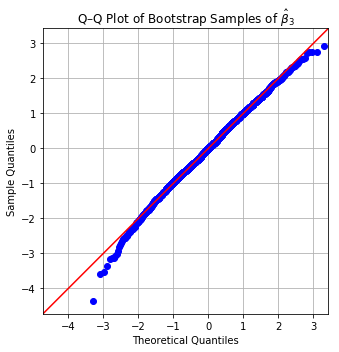

In [87]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
sm.qqplot(bootstrap_samples_cluster[:,3],
          line='45', ax=ax, fit=True)
ax.grid(True)
ax.set_title('Q–Q Plot of Bootstrap Samples of $\\hat\\beta_3$')
ax.set_aspect('equal')
fig.tight_layout()
fig.savefig('qq_bootstrap_cluster.pdf', bbox_inches='tight')

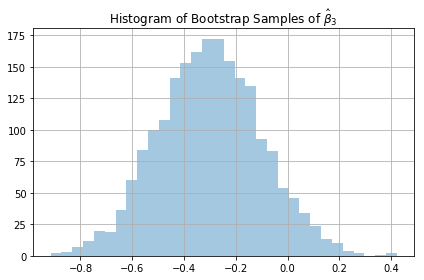

In [91]:
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
ax.grid(True)
sns.distplot(bootstrap_samples_independent[:,3], kde=False, ax=ax)
ax.set_title('Histogram of Bootstrap Samples of $\\hat\\beta_3$')
fig.tight_layout()
fig.savefig('hist_bootstrap_cluster.pdf', bbox_inches='tight')

In [220]:
bootstrap_samples_independent.shape

(2048, 4, 1)

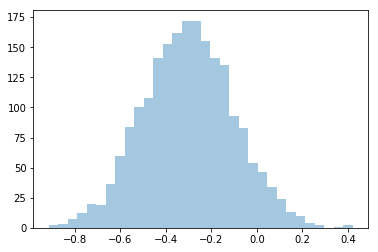

In [187]:
np.squeeze(bootstrap_samples_independent)

array([[21.648651  ,  0.98417586, -0.89475965, -0.31578362],
       [21.884693  ,  1.0079076 , -0.13935333, -0.657391  ],
       [23.005613  ,  0.6692774 , -1.6961492 , -0.16823702],
       ...,
       [22.48869   ,  0.7325147 , -1.3374456 , -0.27941138],
       [22.635717  ,  0.7444124 , -0.9168482 , -0.2588601 ],
       [23.857946  ,  0.6410407 , -2.958365  ,  0.1498677 ]],
      dtype=float32)

In [245]:
np.sqrt(np.var(bootstrap_samples_hierarchical[:,3]))

0.21844482

In [240]:
np.mean(bootstrap_samples_independent[:,3])

-0.30128074

## REML Exchangeable Test

Should agree with numbers from Chapter 2, slides 73 and 75.

In [23]:
log_exchangeable_covariance_params = fit(
    X, y,
    CovarianceSpec(initial_params=[0., 0., 0., 0., -1.],
                   make_covariance=make_covariance_exchangeable))
tf.exp(log_exchangeable_covariance_params).numpy()

array([2.3867779 , 2.058272  , 2.4678187 , 2.19673   , 0.63528943],
      dtype=float32)

In [24]:
solve_beta(X, y, tf.linalg.cholesky_solve(
    tf.linalg.cholesky(
        make_covariance_exchangeable(log_exchangeable_covariance_params)),
    tf.eye(X.shape[-1])))        

<tf.Tensor: id=418373, shape=(4, 1), dtype=float32, numpy=
array([[22.485374  ],
       [ 0.79431295],
       [-1.2507197 ],
       [-0.3155596 ]], dtype=float32)>

In [25]:
tf.sqrt(tf.linalg.diag_part(
    ml_covariance(X, tf.linalg.cholesky_solve(
        tf.linalg.cholesky(
            make_covariance_exchangeable(log_exchangeable_covariance_params)),
        tf.eye(X.shape[-1]))))).numpy()

array([0.5308524 , 0.07701091, 0.8316859 , 0.12065291], dtype=float32)